In [36]:
import json
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import random
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split

from node2vec import Node2Vec
from gensim.models import Word2Vec, KeyedVectors

In [37]:
#load data
with open("/home/vrlab/Documents/HS/Hearthstone_Winrate/dataset/hsreply_data/decks.json", 'r') as f:
    decks_ori = json.load(f)

winrate = []
decks = []
cards = set()

for deck in decks_ori:
    tmp = []
    for card in deck['deck_list']:
        for i in range(card[1]):
            tmp.append(card[0])
    if len(tmp) == 30:
        decks.append(tmp)
        for card in tmp:
            cards.add(card)
        winrate.append(deck['win_rate']/100)

cards = list(cards)

print('cards num:', len(cards))
print('decks num:', len(decks))
print('deck example:', decks[0])
print(winrate[0])

cards num: 958
decks num: 736
deck example: [99957, 99957, 97467, 97467, 100595, 100595, 97406, 97683, 98283, 98283, 98285, 98762, 98762, 97282, 97282, 85154, 85154, 79780, 97528, 97528, 98768, 98768, 86626, 80647, 80647, 101375, 97269, 97269, 97394, 97394]
0.7648


In [3]:
# one hot encode
mapping = np.eye(len(cards))
print(cards)
cards = {cards[i]:mapping[i] for i in range(len(cards))}

decks = [[cards[card] for card in deck] for deck in decks]

decks = np.array(decks)
print(decks.shape)

[69632, 69635, 69636, 69637, 100358, 69638, 71688, 100361, 100362, 100363, 71690, 100365, 71694, 100367, 69643, 100369, 69649, 94225, 69654, 69655, 98328, 71705, 69658, 69660, 69663, 71712, 69665, 84003, 69668, 69667, 84007, 98344, 81961, 94248, 81963, 94251, 69674, 73774, 69683, 81972, 81973, 69684, 69688, 69689, 69691, 79932, 96077, 92222, 92225, 69698, 69700, 92228, 69702, 69703, 92232, 69705, 69706, 92235, 69707, 98377, 98382, 92237, 86092, 69713, 92240, 69718, 69721, 92250, 92249, 75866, 75868, 86109, 86111, 92256, 86112, 69625, 98403, 69731, 71781, 69734, 69735, 86120, 75881, 92266, 98411, 69740, 92268, 69742, 92267, 98417, 98123, 69629, 86132, 69630, 98427, 98434, 86150, 80014, 82067, 80021, 96909, 82072, 82073, 84292, 71841, 84132, 98469, 96422, 92325, 82088, 69640, 92332, 94381, 86190, 92335, 69641, 73906, 92338, 92340, 100537, 100539, 100540, 86209, 100546, 82116, 100553, 102212, 80083, 80085, 98520, 80089, 80090, 86235, 80091, 73721, 102214, 102215, 71917, 102218, 84206, 719

In [38]:
with open('emb_512.txt', 'r') as f:
    num, dim = (int(token) for token in f.readline().split(' '))

    embedding = {}
    for i in range(num):
        line = f.readline().split(' ')
        card = int(line[0])
        emb = np.array([float(e) for e in line[1:]])
        embedding[card] = emb

decks = [[embedding[card] for card in deck] for deck in decks]

decks = np.array(decks)
print(decks.shape)

(736, 30, 512)


In [39]:
# Dataloader
inputs = torch.tensor(decks, dtype=torch.float).to('cuda')
gts = torch.tensor(winrate, dtype=torch.float).to('cuda')

train_dataset = TensorDataset(inputs, gts)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [40]:
from net import Transformer

In [41]:
input_size = decks.shape[2]
hidden_size = 512
output_size = 1
model = Transformer(input_size, input_size, input_size, hidden_size).to('cuda:0')

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

In [45]:
num_epochs = 3000
losses = []
for epoch in tqdm(range(num_epochs)):
    running_loss = 0.0
    # 前向传播
    for input, gt in train_loader:
        # 前向传播
        outputs = model(input)
        loss = criterion(outputs, gt.view(-1, 1))

        # 反向传播和优化
        loss.backward()
        optimizer.step()
        # scheduler.step(loss)
        optimizer.zero_grad()
        # scheduler.step()
        running_loss += loss.item()
    
    losses.append(running_loss)

    plt.show()
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.5f}')
        with torch.no_grad():
            idxs = random.choices(range(len(inputs)), k=2)
            test_outputs = model(inputs[idxs])
            for i in range(2):
                print(f'pred: {test_outputs[i]}, gt: {gts[idxs[i]]}')


torch.save(model.state_dict(), 'model_weights.pth')



  0%|          | 8/3000 [00:04<28:30,  1.75it/s]


KeyboardInterrupt: 

In [43]:
with torch.no_grad():
    inputs = inputs
    test_outputs = model(inputs)
    print(test_outputs.shape)
    for i in range(len(test_outputs)):
        print(f"pred: {test_outputs[i]} gt: {gts[i]}")

    mse = criterion(test_outputs, gts)
    print(f'Mean Squared Error on Test Data: {mse.item():.4f}')

torch.Size([736, 1])
pred: tensor([0.6848], device='cuda:0') gt: 0.7648000121116638
pred: tensor([0.6810], device='cuda:0') gt: 0.7613000273704529
pred: tensor([0.6545], device='cuda:0') gt: 0.7329999804496765
pred: tensor([0.6694], device='cuda:0') gt: 0.7210000157356262
pred: tensor([0.6019], device='cuda:0') gt: 0.6894999742507935
pred: tensor([0.6568], device='cuda:0') gt: 0.6823999881744385
pred: tensor([0.6570], device='cuda:0') gt: 0.6811000108718872
pred: tensor([0.6393], device='cuda:0') gt: 0.675599992275238
pred: tensor([0.6626], device='cuda:0') gt: 0.6744999885559082
pred: tensor([0.6334], device='cuda:0') gt: 0.6722000241279602
pred: tensor([0.6458], device='cuda:0') gt: 0.6699000000953674
pred: tensor([0.6587], device='cuda:0') gt: 0.6669999957084656
pred: tensor([0.6410], device='cuda:0') gt: 0.6654000282287598
pred: tensor([0.6391], device='cuda:0') gt: 0.6599000096321106
pred: tensor([0.6390], device='cuda:0') gt: 0.6546000242233276
pred: tensor([0.6327], device='cuda

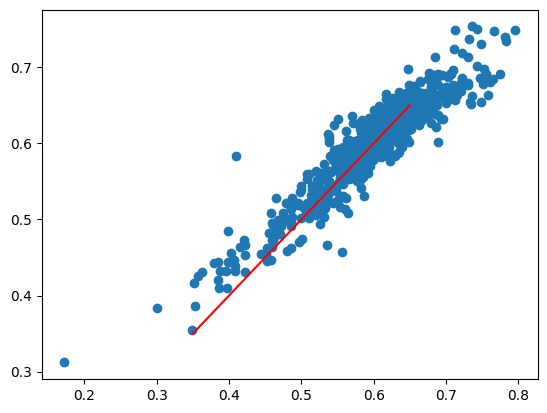

array([[1.        , 0.86904971],
       [0.86904971, 1.        ]])

In [44]:
plt.scatter(winrate,test_outputs.cpu())
plt.plot(np.arange(0.35,.7,0.05),np.arange(0.35,.7,0.05), color='red')
plt.show()

np.corrcoef(winrate,test_outputs.view(-1).cpu())**2

In [35]:
avg_winrate = sum(winrate)/ len(winrate)
print(avg_winrate)

0.6013101902173915
